Importing Packages


In [0]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Modeling, selection, and evaluation
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline 

**Connect Data Source to Collab**

Data is stored in Google Drive and loading into Collab Notebook


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Data Preparation** 

First we read in the data and have a look at the columns we can use and explore


In [4]:
# Read file into dataframe
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('/content/drive/My Drive/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12044,570307434113310720,negative,1.0000,Late Flight,1.0000,American,NaN,LauraMolito,NaN,0,"@AmericanAir stranded for 24 hours in MIA, Patrick casimir has been the ONLY AA staff to apologize for the great inconvenience #unreal",NaN,2015-02-24 11:41:02 -0800,"New York, NY",Atlantic Time (Canada)
9606,569837569392967680,positive,1.0000,NaN,NaN,US Airways,NaN,hegshmeg,NaN,0,“@USAirways: @hegshmeg O” thank you for that elaborate response,NaN,2015-02-23 04:33:58 -0800,los angeles ca,Pacific Time (US & Canada)
4029,567863121479536641,neutral,1.0000,NaN,NaN,United,NaN,FAiRChicago,NaN,1,@united instead of Bourbon street how about #quiet #planes #SaveTheDiagonals,"[42.04836196, -87.74130154]",2015-02-17 17:48:13 -0800,"Chicago, IL",NaN
12669,570068449646346240,neutral,1.0000,NaN,NaN,American,NaN,kiasuchick,NaN,0,@AmericanAir @USAirways I need to Cancelled Flight a flight I booked earlier tonight. Are you able to do it over Twitter?,NaN,2015-02-23 19:51:24 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
13181,569919787888988160,negative,0.6961,Flight Booking Problems,0.6961,American,NaN,Baynhambristol,NaN,0,@AmericanAir 2 months and still no exec platinum member cards. What gives?,NaN,2015-02-23 10:00:40 -0800,New York,Hawaii


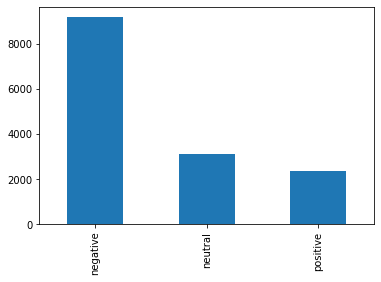

In [6]:
#airline_sentiment, and its breakdown across airlines and tweet length.
df['airline_sentiment'].value_counts().plot(kind='bar')

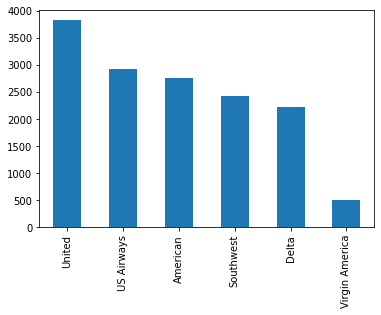

In [7]:
df['airline'].value_counts().plot(kind='bar')

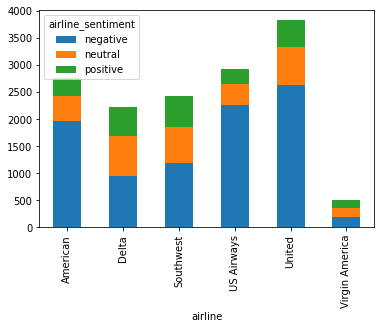

In [8]:
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

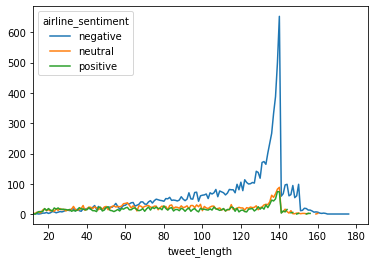

In [9]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)


**Inference**

We see that there isn't a lot of correlation between the number of positive / neutral tweets and the tweet length, but for negative tweets the distribution is heavily skewed towards longer tweets



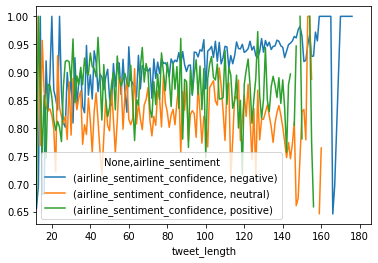

In [10]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).mean().unstack().plot(kind='line', stacked=False)

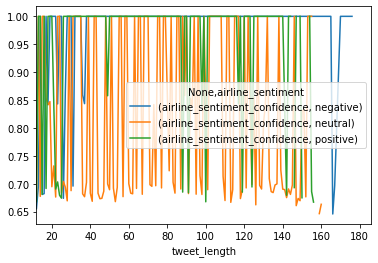

In [11]:
df[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).median().unstack().plot(kind='line', stacked=False)

Randomize and split the data, then write to CSVs.



In [0]:
test_percentage = 0.1
df.sort_index(inplace=True)
cutoff = int(test_percentage * df.shape[0])
df[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
df[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
df[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

**NLP level data preprocessing**

**Tokenization**

read in the data and add new words to dictionary, as well as create a representation of words using numbers.


In [13]:
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
"xxbos @united xxmaj waiting for 3494 xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup ywg at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup ywg in case i miss xxunk ?",negative
xxbos @united - xxmaj kids left a kindle fire xxup hd 6 onboard xxup xxunk ( xxup ord - xxup sfo ) today . xxmaj row xxup xxunk - xxup def ( we had the whole row xxunk the 5 of us ) . xxmaj help ...,neutral
"xxbos @united xxup xxunk from xxup ric , xxup ua507 from xxup ord , & & xxup xxunk from xxup den xxup xxunk xxup delayed for non - weather issues . xxmaj way to go , you re batting xxunk ! xxmaj but no hotels",negative


The following changes have been made to the text for ease of modeling:

split on space and punctuation symbols
the "'s" are grouped together in one token
the contractions are separated like this: "did", "n't"
there are several special tokens (all those that begin by xx), to replace unknown tokens

In [15]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

the current representation post-processing, in both text form and numerical.

In [16]:
print(data.train_ds[0][0])

xxbos @usairways your service in xxmaj philly is unacceptable . xxmaj look into better service ✌ ️ a 16 yr old should nt have a hard time http : / / t.co / xxunk


In [17]:
print(data.train_ds[0][0].data[:10])

[  2  24  39  62  30   5 597  28 420   9]


Language Model

In [0]:
bs = 24
seed = 333

In [19]:
data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [20]:
# data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @united it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @united - rebooked
1,"good to know . xxbos @united okay . xxmaj thanks . xxbos @united xxmaj conference xxunk in 3 hours . xxmaj up all night due to delays and still waiting to talk to someone about lost luggage . xxbos @united xxmaj seat xxup xxunk , xxmaj flight xxup xxunk xxbos @united is it on a flight now ? xxmaj thanks for reply . xxbos @united is xxunk and i am"
2,"and the delay turns into a xxmaj cancelled xxmaj flight ... xxbos @united xxup ua xxunk delayed again - i get charged $ 600 if xxmaj late xxmaj flight by you - you say "" oh well "" xxbos @united we are trying to go as far away from king'scollegelondon as possible for # charity today . xxmaj would you help us ? # jailbreak # xxup rag xxbos @united"
3,"to 1st class . xxmaj xxunk ? xxmaj really ? @united : xxunk xxmaj your xxunk is xxunk xxbos @united xxmaj thanks xxmaj yup i 'm all set . xxmaj it happens . xxup slc ground staff were prompt , helpful and courteous . xxbos xxmaj there were plenty of empty seats in coach "" @united : xxmaj your xxunk is understood . xxmaj crew members traveling for duty are"
4,"when i boarded . xxbos “ @united : xxunk xxmaj sorry to hear about your flight . xxmaj do you need help reflight xxmaj booking xxmaj problems ? ” \n \n 👎 xxbos @united now we are trying to get to xxmaj san xxmaj juan from xxmaj chicago o'hare . xxmaj having lots of problems . xxmaj may get a standby flight . xxbos @united xxmaj alright , thank"


In [21]:
#define the language model and set the learning rates.
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


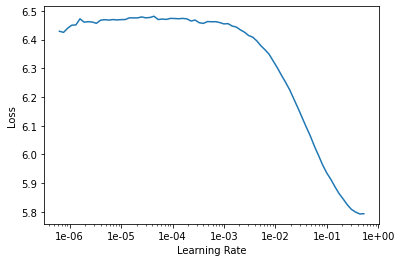

In [27]:
learn.recorder.plot(skip_end=15)

In [28]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.099310,3.800824,0.266875,17:38


In [0]:
learn.save('fit_head')

In [0]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.750819,3.728705,0.277470,18:42
1,3.677052,3.669928,0.286161,19:16
2,3.608504,3.620780,0.292173,18:55
3,3.526817,3.572937,0.296696,19:10
4,3.420647,3.539411,0.300625,19:20


KeyboardInterrupt: ignored

In [0]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

**Classifier**

The encoder from the language model in our classifier, which has a similar LSTM architecture but will predict the sentiment instead of the next word in a tweet. The model architecture here presents some advantages over traditional bags-of-words


In [38]:
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm xxunk at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


In [39]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @united the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk,xxbos @united he is so excellent and so reliable :) # happycustomer,xxbos @united but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers,xxbos @united xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow,xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you
y: CategoryList
negative,positive,negative,neutral,neutral
Path: .;

Valid: LabelList (1317 items)
x: TextList
xxbos @usairways stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous http : / / t.co / xxunk,xxbos @southwestair i consider myself a loyal

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


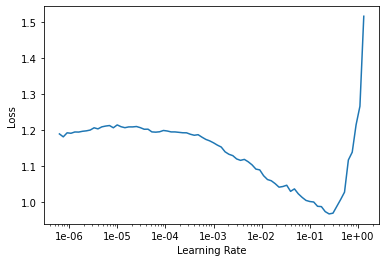

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.694325,0.562797,0.766894,19:52


In [0]:
learn.save('first')

In [46]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.624221,0.499246,0.797267,18:48


In [0]:
learn.save('second')

In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.542702,0.465414,0.811693,18:55


In [49]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.463505,0.460849,0.817008,19:38
1,0.434738,0.449432,0.826879,20:30
2,0.399077,0.449746,0.824601,21:50


***Evaluate Performance on Test Set***

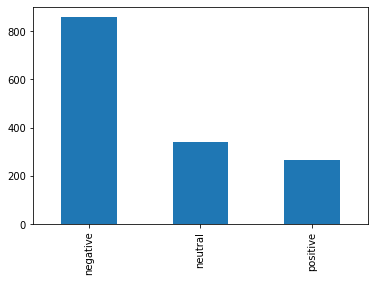

In [50]:
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")
test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [51]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.8005464480874317


In [0]:
# Confusion matrix plotting adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

**Confussion Matrix**


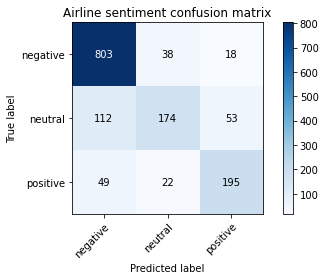

In [54]:
plot_confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
# confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'], labels=['positive', 'neutral', 'negative'])
plt.show()

**Accuracy Score**

In [55]:
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.8005464480874317
